In [1]:
import pandas as pd
import numpy as np
import glob
from tqdm import tqdm, trange

import matplotlib.pyplot as plt
import plotly.express as px
from difflib import SequenceMatcher

In [2]:
def millions(x, pos):
    """The two args are the value and tick position."""
    return '{:1.1f}M'.format(x*1e-6)

## Morbilidad B2

In [3]:
# Morbilidad B2
data = pd.read_pickle('data/morbilidad_b2.csv')

data_lima_p = data[(data['STATE']=='LIMA')].reset_index(drop=True)
data_lima_m = data[(data['PROVINCE']=='LIMA') & (data['STATE']=='LIMA')].reset_index(drop=True)
del data

In [4]:
data_lima_m.head()

,YEAR,MONTH,UBIGEO,STATE,PROVINCE,DISTRICT,SECTOR,CATEGORY,CO_IPRESS,NAME,SEX,AGE,DIAGNOSIS,QTY_PEOPLE_SERVED,DATE
0,2018,1,150101,LIMA,LIMA,LIMA,PRIVADO,II-2,00015610,CLÍNICA INTERNACIONAL,2,7,R10.2,10,2018-01-01
1,2018,1,150101,LIMA,LIMA,LIMA,PRIVADO,II-2,00015610,CLÍNICA INTERNACIONAL,2,7,R10.4,11,2018-01-01
2,2018,1,150101,LIMA,LIMA,LIMA,PRIVADO,II-2,00015610,CLÍNICA INTERNACIONAL,2,7,R11.X,3,2018-01-01
3,2018,1,150101,LIMA,LIMA,LIMA,PRIVADO,II-2,00015610,CLÍNICA INTERNACIONAL,2,7,R16.0,1,2018-01-01
4,2018,1,150101,LIMA,LIMA,LIMA,PRIVADO,II-2,00015610,CLÍNICA INTERNACIONAL,2,7,R42.X,1,2018-01-01


In [20]:
diagnosis = len(data_lima_m['DIAGNOSIS'].unique())
print("Qty of unique diagnosis:",diagnosis)

Qty of unique diagnosis: 10504


#### Qty of Unique diagnoses by disctrict

In [286]:
DIAGNOSIS_PARAMETER = 'DIAGNOSIS'

data_temp = data_lima_m.groupby(['DISTRICT',DIAGNOSIS_PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['DISTRICT']).agg({ DIAGNOSIS_PARAMETER: "count"})
data_temp = data_temp.reset_index()

fig = px.treemap(data_temp,
                 path=[px.Constant('DISTRICTS'),'DISTRICT'],
                 values=DIAGNOSIS_PARAMETER,
                 color=DIAGNOSIS_PARAMETER,
                 hover_data=['DISTRICT'])
fig.show()

#### Qty of hospitals by disctrict

In [287]:
HOSPITAL_PARAMETER = 'CO_IPRESS'

data_temp = data_lima_m.groupby(['DISTRICT',HOSPITAL_PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['DISTRICT']).agg({ HOSPITAL_PARAMETER: "count"})
data_temp = data_temp.reset_index()

fig = px.treemap(data_temp,
                 path=[px.Constant('DISTRICTS'), 'DISTRICT'],
                 values=HOSPITAL_PARAMETER,
                 color=HOSPITAL_PARAMETER,
                 hover_data=['DISTRICT'])
fig.show()

#### Evolution of the top 10 diagnoses

In [283]:
DIAGNOSIS_PARAMETER = 'DIAGNOSIS'

data_temp = data_lima_m.groupby(['DATE', DIAGNOSIS_PARAMETER]).agg({ 'QTY_PEOPLE_SERVED': "count"})
data_temp = data_temp.reset_index()

top10_df = pd.DataFrame()
date_uniques = np.sort(data_temp['DATE'].unique())

for date in date_uniques:
    temp_df = data_temp[data_temp['DATE']==date]
    temp_df = temp_df.sort_values(by=['QTY_PEOPLE_SERVED'], ascending=False)
    temp_df = temp_df.head(10).reset_index(drop=True)
    top10_df = pd.concat([top10_df, temp_df])
    
diagnosis = top10_df[DIAGNOSIS_PARAMETER].unique()

for date in date_uniques:
    temp_df = top10_df[top10_df['DATE']==date]
    diagnosis_temp = list(set(diagnosis) - set(temp_df[DIAGNOSIS_PARAMETER].values))
    temp_df = pd.DataFrame(diagnosis_temp, columns =[DIAGNOSIS_PARAMETER])
    temp_df['DATE']=date
    temp_df['QTY_PEOPLE_SERVED']=0
    top10_df = pd.concat([top10_df, temp_df])

top10_df = top10_df.sort_values(by=['DATE',DIAGNOSIS_PARAMETER], ascending=True)

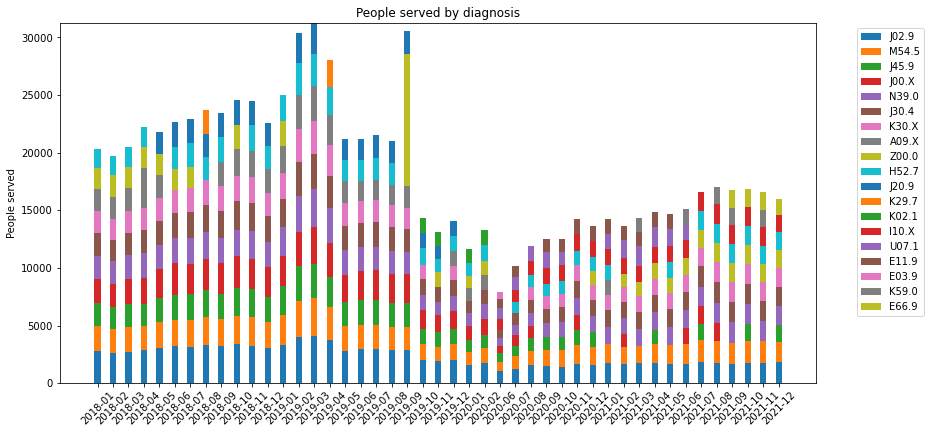

In [284]:

x_element = [str(item)[:7] for item in np.unique(top10_df['DATE'])]
N = len(x_element)
ind = np.arange(N) 
width = 0.40

fig = plt.figure(figsize=(10.5,5))
ax = fig.add_axes([0,0,1,1])

values_temp = 0
for diag in diagnosis:
    temp_df = top10_df[top10_df[DIAGNOSIS_PARAMETER]==diag]
    values = temp_df['QTY_PEOPLE_SERVED'].values
    ax.bar(ind, values, width, bottom=values_temp)
    values_temp = values_temp + values

ax.set_ylabel('People served')
ax.set_title('People served by diagnosis')
ax.set_xticks(ind)
ax.set_xticklabels(x_element, rotation=45)

ax.legend(labels=diagnosis, bbox_to_anchor = (1.15, 1))
plt.show()

numero de diagnosticos distintos por hospitales, un grafico por categoria
#### Diagnoses qty by hospitals and hospital category

In [296]:
HOSPITAL_PARAMETER = 'CO_IPRESS'

def category_label(val):
    category_label = None
    if val in ['I-3', 'I-4']:
        category_label = 'I'
    elif val in ['II-1', 'II-2', 'II-E']:
        category_label = 'II'
    elif val in ['III-1', 'III-2', 'III-E']:
        category_label = 'III'
    else:
        pass
        category_label = '0'
    return category_label

data_temp = data_lima_m.groupby(['CATEGORY', HOSPITAL_PARAMETER,'DIAGNOSIS']).agg({ 'QTY_PEOPLE_SERVED': "sum"})
data_temp = data_temp.reset_index()
data_temp = data_temp.groupby(['CATEGORY', HOSPITAL_PARAMETER]).agg({ 'DIAGNOSIS': "count"})
data_temp = data_temp.reset_index()
data_temp['CATEGORY2'] = data_temp['CATEGORY'].apply(lambda x : category_label(x))

fig = px.treemap(data_temp,
                 path=[px.Constant('CATEGORY2'),'CATEGORY2', 'CO_IPRESS'],
                 values='DIAGNOSIS',
                 color='DIAGNOSIS',
                 hover_data=['DIAGNOSIS'])
fig.show()

In [63]:
# numero de diacnosticos unicos por distrito
# numero de hospitales y clinicas por distrito
# evolucion del top 10 de diagnosticos a traves del tiempo por años
# numero dediagnosticos distintos por hospitales, un grafico por categoria
# cateforia I-3, I-4
# categira II y categoria II
# c*III


# Razon social y códigos